# Build binary classifier to predict disease status from methylation biomarker 

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
from scipy.stats import ttest_ind

# Data
- `mock.tsv` contains methylation data from 150 individuals as follows:
- A_xx, B_xx: methylation data from two orthogonal methods, e.g. A_0 is methylation measurement by method A at CpG site index 0. 
- Label: `1` (disease), `0` (no disease). There are 50 individuals with label 1 and 100 individuals with label 0.
- Cohort: There are 3 cohort groups (`Aug`, `Jul`, `Mar`), each with 50 individuals
- Cohort: Data from same cohort are from the same batch of experiment. All the data are from the identical biological population. Any differences between different Cohorts is not due to internal factor (e.g. health condition) but due to external factors (e.g. different experimental conditions or seasonal effect).   

In [2]:
# 1) Load your data
df = pd.read_csv('../data/mock.tsv', sep='\t')   # or wherever your file lives
df

,Cohort,Label,A_0,A_1,A_2,A_3,A_4,A_5,A_6,A_7,...,B_90,B_91,B_92,B_93,B_94,B_95,B_96,B_97,B_98,B_99
0,Aug,0,1.621774,1.739324,1.451617,-0.186583,2.376608,2.295373,2.722720,1.821542,...,0.864761,0.134935,0.242494,0.359284,0.003831,0.069875,0.259369,0.244837,0.554309,0.733232
1,Aug,0,2.767240,1.079509,-0.723664,1.737466,1.844370,2.059156,2.358058,1.868140,...,0.030889,0.226631,0.329706,0.826815,0.317215,0.114622,0.588142,0.668808,0.491239,0.572640
2,Aug,0,2.122517,0.713271,2.915116,1.313582,2.152386,0.885216,2.853469,0.424814,...,0.830995,0.242558,0.841052,0.958406,0.721642,0.753970,0.840054,0.979133,0.357064,0.194532
3,Aug,0,1.802962,3.129745,2.488166,0.917015,2.729987,1.810858,2.108782,0.664469,...,0.391327,0.153289,0.214403,0.113282,0.563799,0.164133,0.262977,0.387080,0.846162,0.564837
4,Aug,0,0.367035,2.749154,1.558293,1.304794,0.857214,3.152263,1.684176,1.667096,...,0.029424,0.986045,0.232829,0.953272,0.918123,0.857471,0.303726,0.404233,0.050626,0.203764
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,Mar,1,-1.682147,-1.262470,-3.842003,-2.204974,-0.902512,0.520465,-1.227517,-0.628699,...,0.509399,0.705261,0.230260,0.958283,0.673974,0.601420,0.256721,0.232084,0.994775,0.611156
146,Mar,1,-1.386700,-1.253194,-1.945290,-3.505696,-1.847696,-0.841383,-1.970503,-2.129677,...,0.146937,0.603260,0.806180,0.410741,0.930247,0.837703,0.330396,0.603705,0.338051,0.464377
147,Mar,1,0.296081,-1.919121,0.350761,-1.491252,-1.950832,-2.100143,-1.230885,-0.888188,...,0.991078,0.623959,0.127712,0.553945,0.162934,0.777856,0.835434,0.857982,0.725078,0.798173
148,Mar,1,-1.528270,-2.667680,-1.118364,-2.586643,-1.151861,-1.574978,-3.201278,-2.337745,...,0.080779,0.995426,0.707016,0.680826,0.738497,0.551783,0.526466,0.421607,0.851696,0.403886


In [3]:
df.describe()

,Label,A_0,A_1,A_2,A_3,A_4,A_5,A_6,A_7,A_8,...,B_90,B_91,B_92,B_93,B_94,B_95,B_96,B_97,B_98,B_99
count,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,...,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000
mean,0.333333,0.015220,0.140165,0.021821,-0.030985,0.068323,0.037672,0.009450,0.065126,0.062814,...,0.513884,0.506445,0.469890,0.539114,0.519623,0.516196,0.477588,0.478443,0.504669,0.508435
std,0.472984,1.464204,1.572276,1.594300,1.574234,1.599172,1.576521,1.588574,1.471894,1.475776,...,0.295635,0.280242,0.278824,0.304114,0.294974,0.289017,0.294289,0.291993,0.301260,0.284987
min,0.000000,-3.420240,-4.041328,-4.124623,-4.132140,-3.332007,-3.490635,-4.069157,-3.223239,-4.292058,...,0.024421,0.008030,0.001550,0.001515,0.003831,0.003074,0.008614,0.000122,0.005974,0.012785
25%,0.000000,-1.110903,-1.108050,-1.200538,-1.072789,-1.161243,-1.138308,-1.147728,-0.929168,-1.011457,...,0.247721,0.262947,0.230617,0.272162,0.215464,0.255202,0.227311,0.209908,0.230311,0.245110
50%,0.000000,0.147722,0.157458,0.145486,-0.075126,0.313973,0.049026,0.038208,-0.144688,0.023032,...,0.528238,0.505223,0.446633,0.549464,0.571182,0.528890,0.470972,0.485379,0.493107,0.555164
75%,1.000000,1.131175,1.336413,1.206092,1.100301,1.168958,1.097209,1.167444,1.161484,1.002566,...,0.780865,0.708282,0.734517,0.799381,0.763507,0.753091,0.700890,0.735972,0.779448,0.749168
max,1.000000,3.972569,4.191416,3.771835,3.142500,3.672911,3.668122,3.496951,4.411386,4.697143,...,0.991078,0.995426,0.993179,0.995125,0.999196,0.994905,0.996274,0.994491,0.995594,0.990170


In [4]:
df.Cohort.unique()

array(['Aug', 'Jul', 'Mar'], dtype=object)

In [5]:
for cohort in df['Cohort'].unique():
    count = (df['Cohort'] == cohort).sum()
    print(f"Num of samples with Cohort == {cohort}: {count}")

print(f"Num of sample with Label == 0 is {sum(df.Label==0)}")
print(f"Num of sample with Label == 1 is {sum(df.Label==1)}")    


Num of samples with Cohort == Aug: 50
Num of samples with Cohort == Jul: 50
Num of samples with Cohort == Mar: 50
Num of sample with Label == 0 is 100
Num of sample with Label == 1 is 50


# Compare singal level between label 1 vs label 0 for each feature
* A47 looks significantly different between the two groups (label0 vs label1)

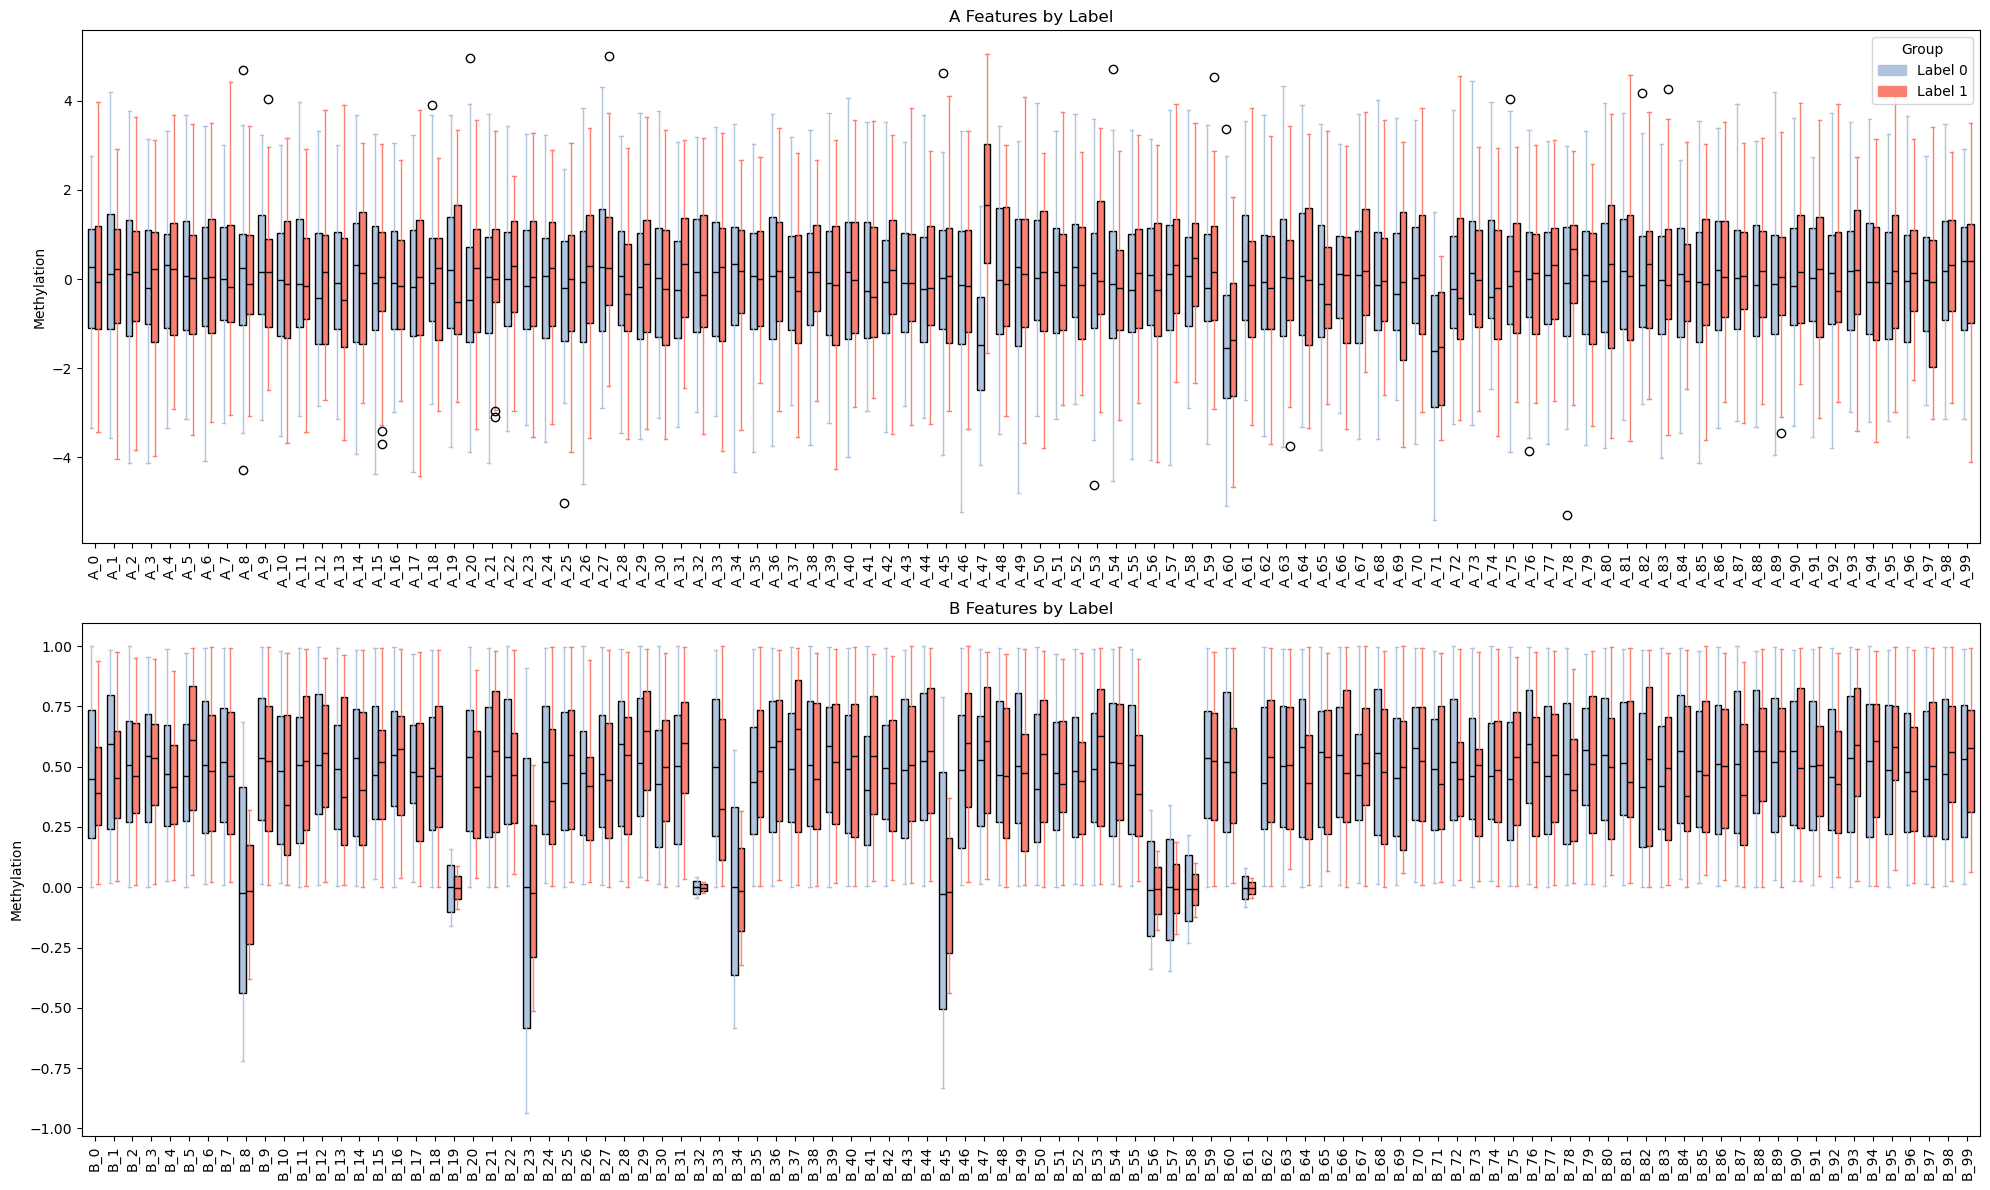

In [6]:
# 1) Identify features & labels
features_A = [c for c in df.columns if c.startswith('A_')]
features_B = [c for c in df.columns if c.startswith('B_')]
labels     = sorted(df['Label'].unique())

# 2) Plot setup
width = 0.35
colors = {0: "lightsteelblue", 1: "salmon"}

fig, axes = plt.subplots(2, 1, figsize=(20, 12), sharex=False)

for ax, features, title in zip(axes,
                               [features_A, features_B],
                               ['A Features', 'B Features']):
    x = np.arange(len(features))
    for idx, label in enumerate(labels):
        data = [df[df['Label'] == label][feat] for feat in features]
        positions = x + (idx - 0.5) * width
        bp = ax.boxplot(data, positions=positions, widths=width, patch_artist=True)
        for box in bp['boxes']:
            box.set_facecolor(colors[label])
        for component in ('whiskers','caps','medians'):
            for art in bp[component]:
                art.set_color(colors[label] if component!='medians' else 'black')
    ax.set_title(f'{title} by Label')
    ax.set_xticks(x)
    ax.set_xticklabels(features, rotation=90)
    ax.set_ylabel('Methylation')

# build one shared legend on the first subplot
patches = [mpatches.Patch(color=colors[l], label=f'Label {l}') for l in labels]
axes[0].legend(handles=patches, loc='upper right', title='Group')

plt.tight_layout()
plt.show()

# t-test to yield p-value between the two groups (label 0 vs label 1) per feature 
* A47 is the unique feature that is significantly different from group label 0 and label 1 with p-value ~ e(-18)

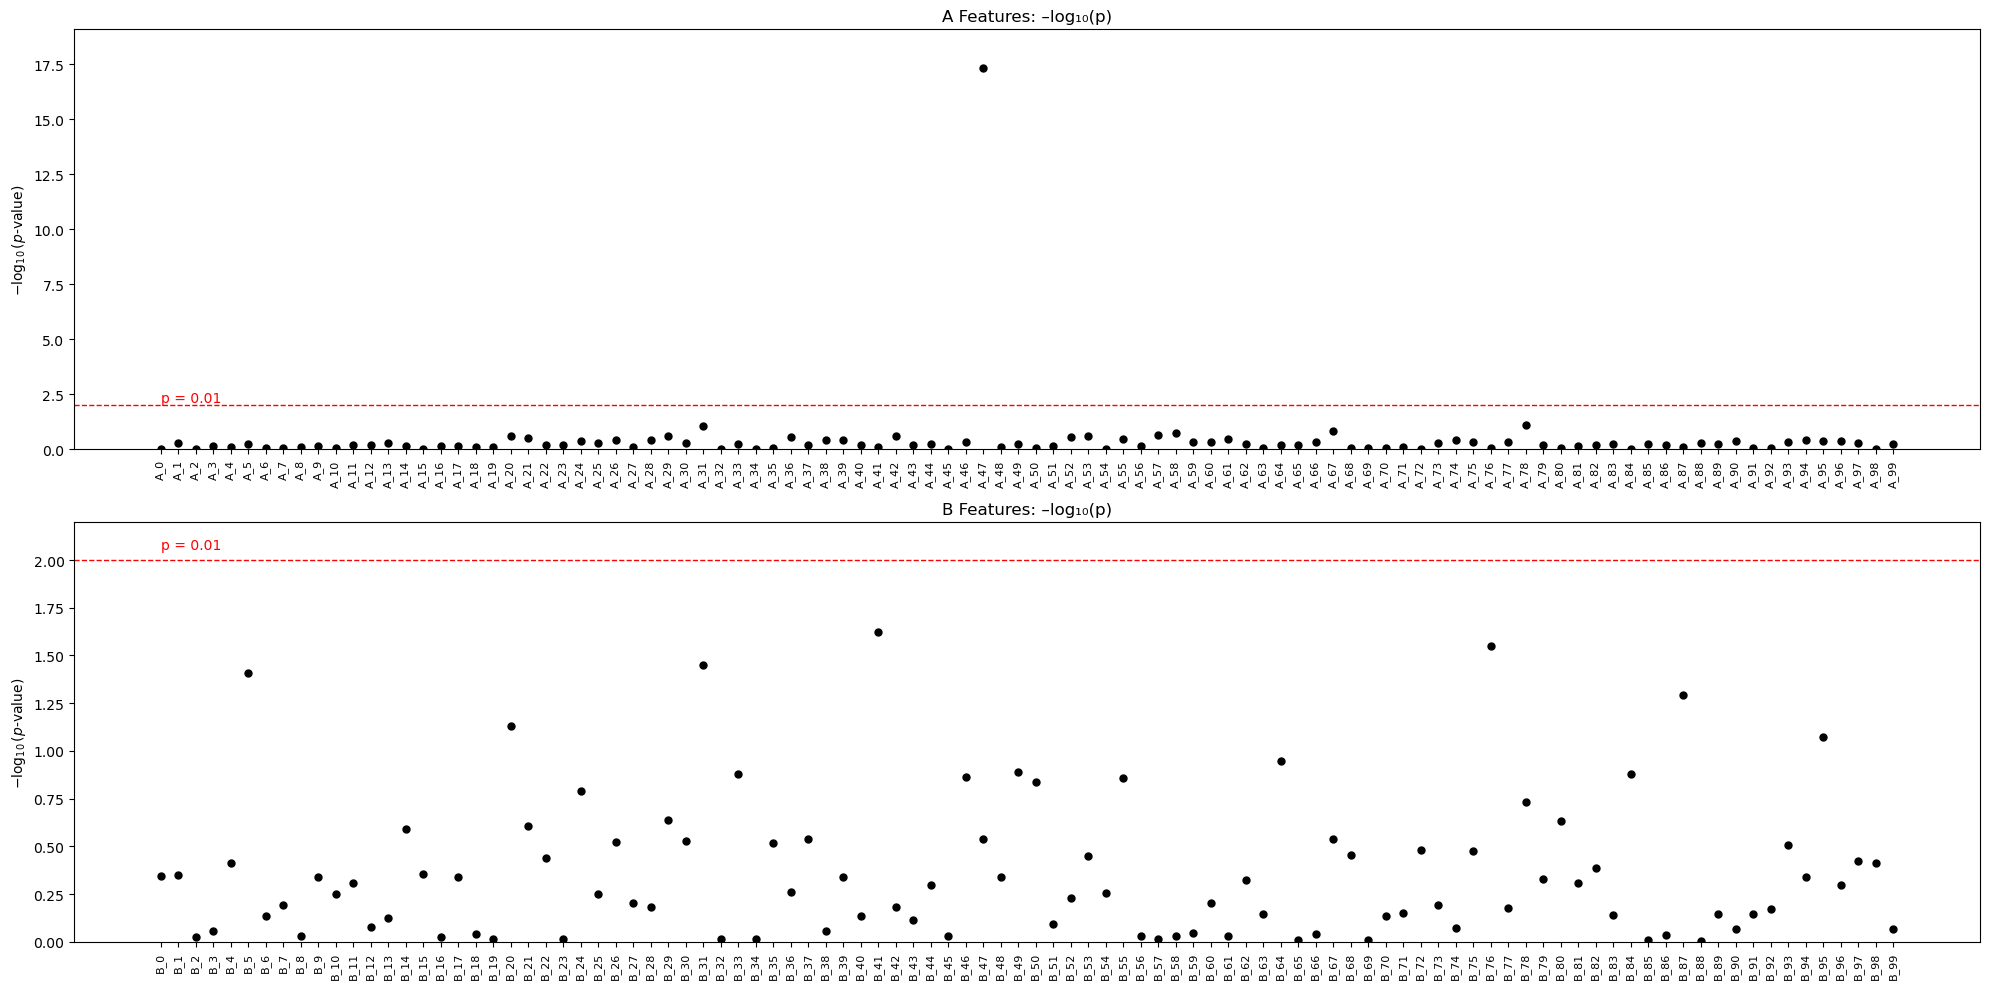

In [7]:
# 2) Prepare subplots
fig, axs = plt.subplots(2, 1, figsize=(20, 10), sharex=False)

for ax, features, title in zip(
    axs,
    [features_A, features_B],
    ['A Features: –log₁₀(p)', 'B Features: –log₁₀(p)']
):
    # compute p-values
    pvals = []
    for feat in features:
        g0 = df.loc[df['Label'] == labels[0], feat].dropna()
        g1 = df.loc[df['Label'] == labels[1], feat].dropna()
        _, p = ttest_ind(g0, g1, equal_var=False)
        pvals.append(p)
    minus_log_p = -np.log10(pvals)

    # scatter plot
    x = np.arange(len(features))
    ax.scatter(x, minus_log_p, color='black', s=25, zorder=5)

    # formatting
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(features, rotation=90, fontsize=8)
    ax.set_ylabel(r'$-\log_{10}(p\text{-value})$')

    # optional: mark significance threshold at p=0.01
    sig_line = -np.log10(0.01)
    ax.set_ylim(0, max(np.max(minus_log_p), sig_line) * 1.1)  # add a little headroom
    ax.axhline(sig_line, color='red', linestyle='--', linewidth=1)
    ax.text(0, sig_line * 1.02, 'p = 0.01', color='red', va='bottom')

plt.tight_layout()
plt.show()


# A47 is a feature to differentiate label 0 vs label 1

In [8]:
select_feature = 'A_47'

In [9]:
def plot_feature_vs_label(
    df,
    feature: str,
    bins: int = 20,
    colors: tuple = ('red', 'blue'),
    figsize: tuple = (12, 5)
):
    """
    Compare the distribution of `feature` between Label=0 and Label=1:
      1) jittered scatter of feature vs label
      2) overlapping histograms
    Annotates Welch’s t-test p-value.
    """
    # Split out the two classes
    x0 = df.loc[df['Label'] == 0, feature].dropna()
    x1 = df.loc[df['Label'] == 1, feature].dropna()

    # Welch’s t-test
    _, pval = ttest_ind(x0, x1, equal_var=False)

    # Build the subplots
    fig, (ax_scatter, ax_hist) = plt.subplots(1, 2, figsize=figsize)

    # Scatter (with vertical jitter)
    jitter0 = np.random.uniform(-0.02, 0.02, size=len(x0))
    jitter1 = np.random.uniform(-0.02, 0.02, size=len(x1))
    ax_scatter.plot(x0, jitter0, '.', color=colors[0], alpha=0.6, label='Label=0')
    ax_scatter.plot(x1, 1 + jitter1, '.', color=colors[1], alpha=0.6, label='Label=1')
    ax_scatter.set_xlabel(feature)
    ax_scatter.set_ylabel('Label')
    ax_scatter.set_yticks([0, 1])
    ax_scatter.set_yticklabels(['0', '1'])
    ax_scatter.set_title(f'{feature} vs. Label (scatter)')
    ax_scatter.legend()

    # Overlapping histograms
    ax_hist.hist(x0, bins=bins, alpha=0.6, color=colors[0], label='Label=0')
    ax_hist.hist(x1, bins=bins, alpha=0.6, color=colors[1], label='Label=1')
    ax_hist.set_xlabel(feature)
    ax_hist.set_ylabel('Count')
    ax_hist.set_title(f'Distribution of {feature} by Label')
    ax_hist.legend()

    # Annotate p-value
    ax_hist.text(
        0.95, 0.95, f"p = {pval:.2e}",
        transform=ax_hist.transAxes,
        ha='right', va='top',
        fontsize=12,
        bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=0.5)
    )

    plt.tight_layout()
    return fig, (ax_scatter, ax_hist)


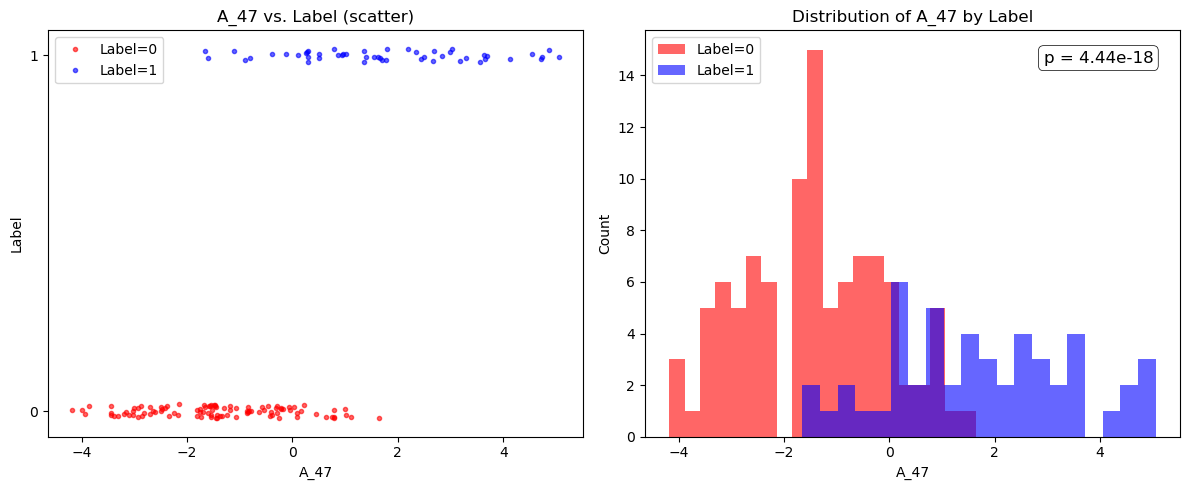

In [10]:
fig, (ax1, ax2) = plot_feature_vs_label(df, select_feature)

# Logistic regression binary classifier with A_47
* Logistic regression can be used as a quick test. 
* Test AUC-ROC: 0.870

In [11]:
def train_and_plot_lr(
    df,
    feature: str,
    label: str = 'Label',
    test_size: float = 0.2,
    random_state: int = 42,
    solver: str = 'liblinear',
    figsize: tuple = (6, 4)
):
    """
    Train a 1-D logistic regression on df[[feature]] vs df[label],
    print classification metrics, and plot the ROC curve.

    Returns:
        clf        : trained LogisticRegression
        X_test     : feature DataFrame for test set
        y_test     : labels for test set
        y_proba    : predicted probability of class 1 on X_test
    """
    # 1) Split off a hold-out test set
    X = df[[feature]]
    y = df[label]
    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=test_size,
        stratify=y,
        random_state=random_state
    )

    # 2) Fit logistic regression
    clf = LogisticRegression(solver=solver, random_state=random_state)
    clf.fit(X_train, y_train)

    # 3) Predict & print metrics
    y_pred  = clf.predict(X_test)
    y_proba = clf.predict_proba(X_test)[:, 1]
    auc     = roc_auc_score(y_test, y_proba)

    print(f"Test AUC-ROC: {auc:.3f}\n")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    # 4) Plot ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.figure(figsize=figsize)
    plt.plot(fpr, tpr, lw=2, label=f"{feature} (AUC = {auc:.2f})")
    plt.plot([0,1],[0,1], 'k--', alpha=0.5)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve for {feature}")
    plt.legend(loc="lower right")
    plt.grid(alpha=0.3)
    plt.show()

    return clf, X_test, y_test, y_proba

Test AUC-ROC: 0.870

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.85      0.85        20
           1       0.70      0.70      0.70        10

    accuracy                           0.80        30
   macro avg       0.77      0.77      0.77        30
weighted avg       0.80      0.80      0.80        30



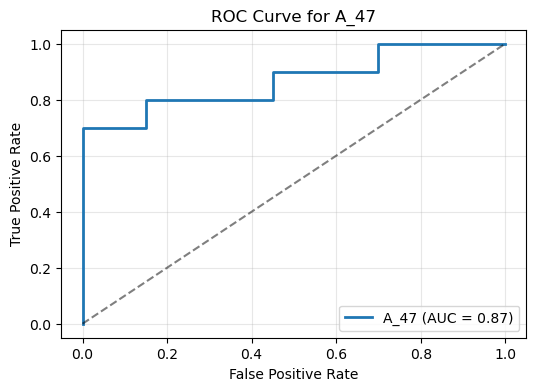

In [12]:
clf, X_test, y_test, y_proba = train_and_plot_lr(df, feature='A_47')

# There is a batch effect by cohort which can be eliminated by offset

In [13]:
def plot_feature_by_cohort_label(df, feature: str, cohorts=None, labels=(0, 1), width=0.6, figsize=(10, 6), colors=('lightsteelblue', 'salmon')
):
    """
    Plot boxplots of `feature` broken out by `cohorts` and `labels`.

    Parameters:
    -----------
    df        : pandas.DataFrame
        Your data containing `feature`, 'Cohort', and 'Label' columns.
    feature   : str
        Name of the numeric column to plot.
    cohorts   : list-like, optional
        Sequence of cohort names. Defaults to sorted unique values in df['Cohort'].
    labels    : tuple of int, optional
        The two label values to compare (default (0, 1)).
    width     : float, optional
        Width of each box.
    figsize   : tuple, optional
        Figure size.
    colors    : tuple of str, optional
        Two colors to alternate between labels.

    Returns:
    --------
    fig, ax : matplotlib Figure and Axes
    """
    if cohorts is None:
        cohorts = sorted(df['Cohort'].unique())

    # 1) Gather data and x-positions
    data, positions, xticks = [], [], []
    step = len(labels) + 1
    for i, cohort in enumerate(cohorts):
        for j, lab in enumerate(labels):
            subset = df.loc[(df['Cohort']==cohort) & (df['Label']==lab), feature]
            data.append(subset.dropna())
            pos = i * step + j
            positions.append(pos)
            xticks.append(f"{cohort}\nLabel {lab}")

    # 2) Create boxplot
    fig, ax = plt.subplots(figsize=figsize)
    bp = ax.boxplot(data, positions=positions, widths=width, patch_artist=True)

    # 3) Color boxes
    box_colors = colors * len(cohorts)
    for patch, col in zip(bp['boxes'], box_colors):
        patch.set_facecolor(col)

    # 4) Ticks and styling
    ax.set_xticks(positions)
    ax.set_xticklabels(xticks, rotation=45, ha='right')
    ax.set_ylabel(feature)
    ax.set_title(f"{feature} by Cohort and Label")
    ax.axhline(0, color='gray', linewidth=0.8)

    plt.tight_layout()
    return fig, ax

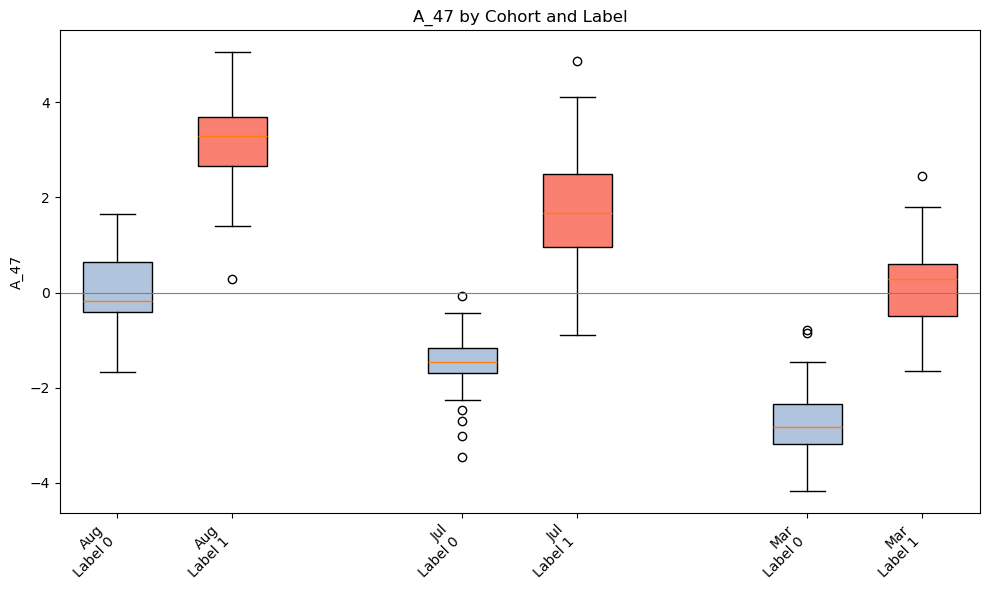

In [14]:
fig, ax = plot_feature_by_cohort_label(df, select_feature)
plt.show()


# Offset cohort effect 
* The trend between Label 0 vs Label 1 is consistent, but there is batch effect among different Cohort. 
* The cohort effect is adjusted by offset the mean per each cohort. 

In [15]:
# 2) Create an adjusted column
select_feature_adj = select_feature + '_cohort_adj'
df[select_feature_adj] = df.groupby('Cohort')[select_feature].transform(lambda x: x - x.mean())

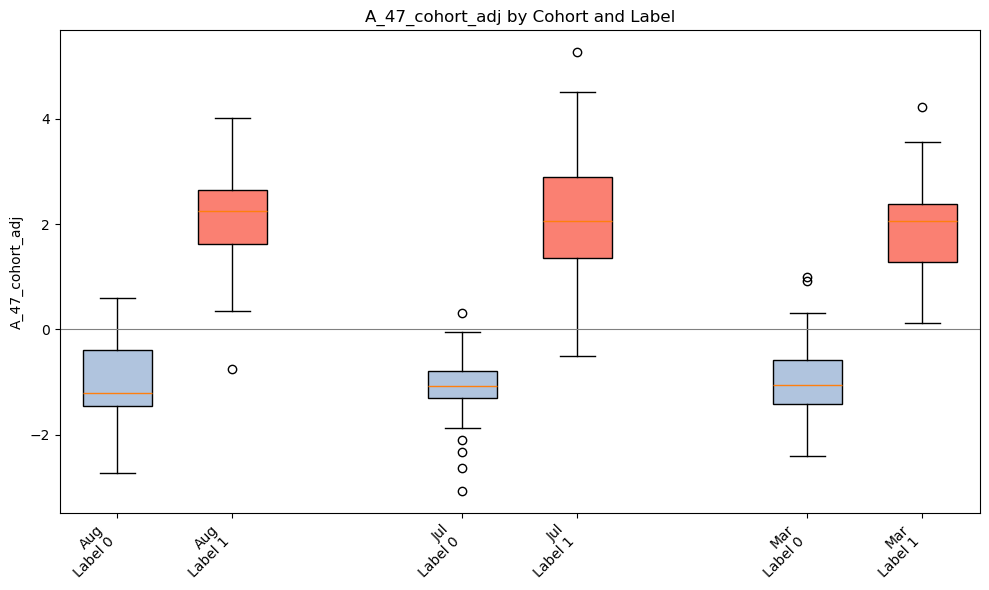

In [16]:
fig, ax = plot_feature_by_cohort_label(df, select_feature_adj)
plt.show()

# Adjusted feature A_47 yields p-value ~ e-25

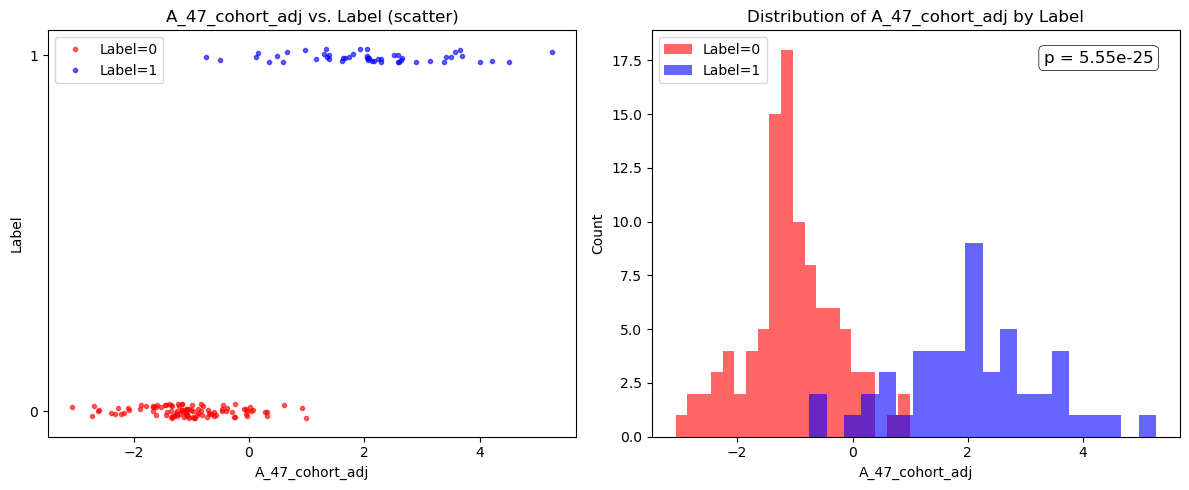

In [17]:
fig, (ax1, ax2) = plot_feature_vs_label(df, select_feature_adj)

# Logistic regression binary classifier with A_47_cohort_adj
* Logistic regression by cohort adjusted A_47 yields Test AUC-ROC: 0.980

Test AUC-ROC: 0.980

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.95      0.95        20
           1       0.90      0.90      0.90        10

    accuracy                           0.93        30
   macro avg       0.93      0.93      0.93        30
weighted avg       0.93      0.93      0.93        30



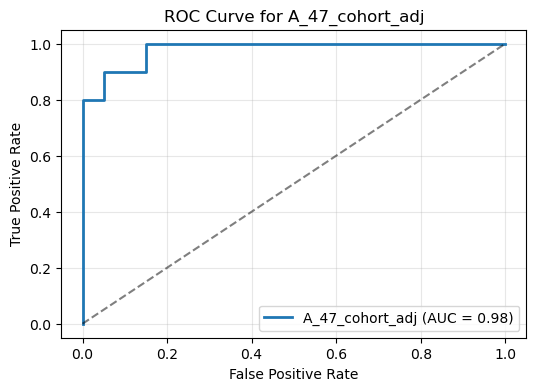

In [18]:
clf, X_test, y_test, y_proba = train_and_plot_lr(df, feature='A_47_cohort_adj')

# New Approach: Percentile Rank-Based Feature for Internal Adjustment
- In practice, using a logistic regression trained on a single raw feature (A_47) may not generalize well across batches.  
- For a new patient, we’d like to predict disease status from their feature set (A_xx, B_xx) using our trained classifier on A_47. But without cohort membership, we can’t compute a batch mean to normalize A_47, so batch effects remain uncorrected.  
- Instead, we can convert each feature to its within-sample rank (or percentile) across all A_xx/B_xx values for that patient. Since batch effects shift raw values uniformly, the relative rank of A_47 should stay consistent regardless of cohort. This rank-based feature is thus internally adjusted for batch effects and more robust.


In [19]:
# 2) Compute row-wise percentile ranks (0.0–1.0) across the A-block
row_pct = df[features_A].rank(axis=1, pct=True)

# 3) Extract A_47’s percentile into its own column
df['A_47_rank_pct'] = row_pct['A_47'] * 100  # convert to percentage

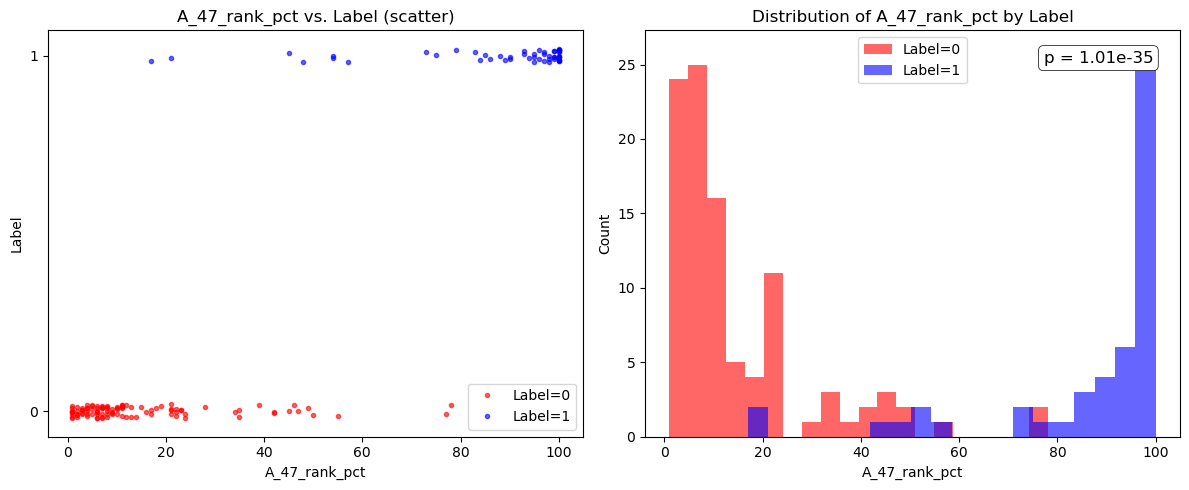

In [20]:
fig, (ax1, ax2) = plot_feature_vs_label(df, 'A_47_rank_pct')

Test AUC-ROC: 0.985

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.90      0.92        20
           1       0.82      0.90      0.86        10

    accuracy                           0.90        30
   macro avg       0.88      0.90      0.89        30
weighted avg       0.90      0.90      0.90        30



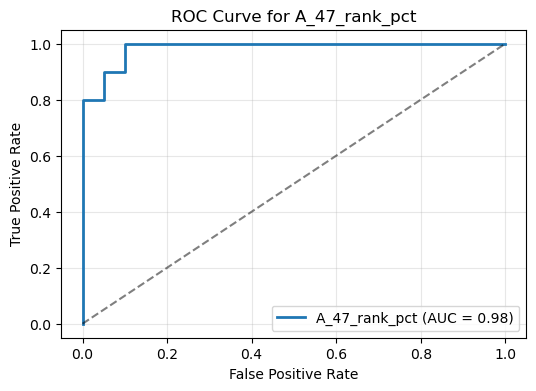

In [21]:
clf, X_test, y_test, y_proba = train_and_plot_lr(df, feature='A_47_rank_pct')

# Conclusion

- Using the within-patient percentile rank of **A_47** as the sole feature in a logistic regression classifier provides a robust prediction of disease status without requiring cohort information.  
- The percentile ranks of **A_47** differ significantly between Label 0 and Label 1 groups (Welch’s t-test p ≈ 1 × 10⁻³⁵).  
- This method achieves a test AUC-ROC of **0.985**.